In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers as L
from tensorflow.keras import callbacks, utils

import re
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaTokenizer

# Loading the Data

In [2]:
dataset = fetch_20newsgroups(subset='all')

X = pd.Series(dataset['data'])
y = pd.Series(dataset['target'])
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=19
)
y_train = pd.get_dummies(y_train)
y_valid = pd.get_dummies(y_valid)

**Constants**

In [3]:
vocab_size = 10_000
embed_dim = 128
seq_length = 256
MAX_EPOCHS = 100

# Building the Tokenizer

In [4]:
tokenizer = ByteLevelBPETokenizer()
tokenizer.train_from_iterator(
    iterator=X_train.values.tolist(), 
    vocab_size=vocab_size,
    special_tokens=['<s>', '<pad>', '</s>', '<unk>', '<mask>']
)
os.mkdir('tokenizer')
tokenizer.save_model('tokenizer')        

tokenizer = RobertaTokenizer.from_pretrained('tokenizer')
def tokenize(texts):
    return tokenizer(
        texts, padding='max_length', truncation=True, max_length=seq_length, 
        return_tensors='np'
    )['input_ids']

**Tokenizing the text**

In [5]:
X_train = tokenize(X_train.values.tolist())
X_valid = tokenize(X_valid.values.tolist())

# Modelling
**Building the Model**


2022-09-22 12:10:44.543047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 12:10:44.635131: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 12:10:44.635870: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-22 12:10:44.637040: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 256, 128)          1280000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 256, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 256, 64)           32832     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 64)           16448     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 64)           0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 64)           0         
_________________________________________________________________
gru (GRU)                    (None, 32)                9

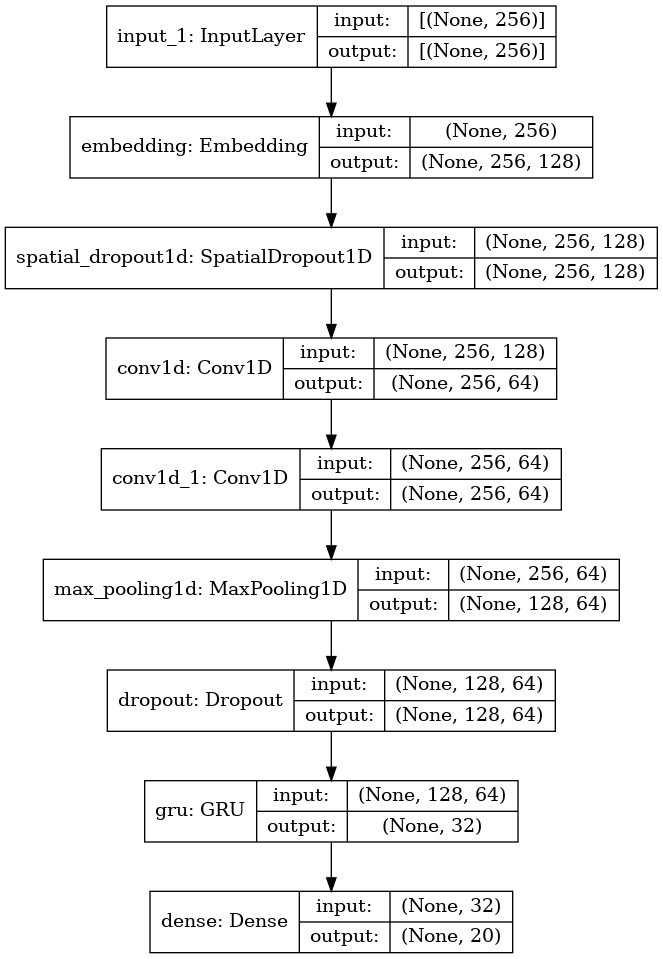

In [6]:
model = models.Sequential([
    L.Input(shape=(seq_length)),
    L.Embedding(vocab_size, embed_dim, input_length=seq_length),
    L.SpatialDropout1D(0.3),
    L.Conv1D(64, 4, padding='same', activation='relu'),
    L.Conv1D(64, 4, padding='same', activation='relu'),
    L.MaxPool1D(2),
    L.Dropout(0.3),
    L.GRU(32),
    L.Dense(20, activation='softmax')
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
es = callbacks.EarlyStopping(
    monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True
)
rlp = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)
utils.plot_model(model, show_shapes=True)

In [7]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid),
    callbacks=[es, rlp], epochs=MAX_EPOCHS
)
model.save('1dCNN-GRU.h5')

2022-09-22 12:10:48.563092: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-09-22 12:10:50.893681: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


531/531 [==============================] - 13s 9ms/step - loss: 2.8334 - accuracy: 0.0860 - val_loss: 2.5490 - val_accuracy: 0.1326
Epoch 2/100
531/531 [==============================] - 5s 9ms/step - loss: 2.2623 - accuracy: 0.1825 - val_loss: 2.0301 - val_accuracy: 0.2584
Epoch 3/100
531/531 [==============================] - 5s 9ms/step - loss: 1.8032 - accuracy: 0.3206 - val_loss: 1.6844 - val_accuracy: 0.3873
Epoch 4/100
531/531 [==============================] - 5s 9ms/step - loss: 1.4263 - accuracy: 0.4774 - val_loss: 1.3314 - val_accuracy: 0.5300
Epoch 5/100
531/531 [==============================] - 5s 9ms/step - loss: 1.1010 - accuracy: 0.6111 - val_loss: 1.2057 - val_accuracy: 0.6191
Epoch 6/100
531/531 [==============================] - 5s 9ms/step - loss: 0.8895 - accuracy: 0.7109 - val_loss: 1.0697 - val_accuracy: 0.6796
Epoch 7/100
531/531 [==============================] - 5s 9ms/step - loss: 0.6845 - accuracy: 0.7832 - val_loss: 0.8419 - val_accuracy: 0.7517
Epoch 8/10